# Задача 3. Многоклассовая классификация и множественная классификация/регрессия

#### Пелогейко Макар Андреевич, 471

* **Дедлайн**: 11.12.2022, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Изучите [возможности sklearn](https://scikit-learn.org/stable/modules/multiclass.html#multiclass-classification) для решения задач **Multiclass classification**, **Multilabel classification** и **Multioutput Regression**. Основные компоненты библиотеки указаны на рисунке ниже.
![multi_org_chart](https://scikit-learn.org/stable/_images/multi_org_chart.png)

- [x] Найдите данные, на которых можно решить задачу **Multiclass classification** (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя стратегии **OneVsRest**, **OneVsOne** и **OutputCode** решите задачу **Multiclass classification** для каждого из пройденных базового алгоритма классификации (**logistic regression, svm, knn, naive bayes, decision tree**). При обучении использовать **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания.
- [x] Замерить время обучения каждой модели для каждой стратегии.
- [x] Для оценки качества моделей используйте метрику **AUC-ROC**.
- [x] Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.
- [ ] * (**+3 балла**) Повторить все пункты для задачи **Multilabel classification** (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать **MultiOutputClassifier** и **ClassifierChain**.
- [ ] * (**+2 балла**) Повторить все пункты для задачи **Multioutput Regression** (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: **Ridge**. В качестве стратегий попробовать **MultiOutputRegressor** и **RegressorChain**. В качестве метрики использовать **R2**.

In [236]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.datasets import load_wine
import time

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier

### Подготовка данных

In [237]:
wine=load_wine()

df=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])


df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [239]:
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [240]:
df.target.unique()

array([0., 1., 2.])

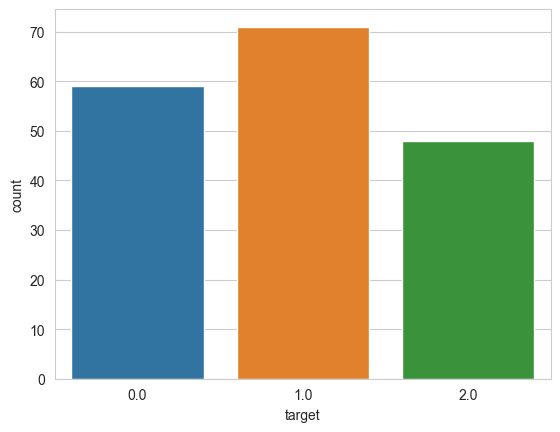

In [241]:
sns.countplot(x="target", data=df)
plt.show()

In [242]:
df['target'].value_counts()

1.0    71
0.0    59
2.0    48
Name: target, dtype: int64

In [243]:
df[['alcohol','magnesium','color_intensity']].corr()

,alcohol,magnesium,color_intensity
alcohol,1.000000,0.270798,0.546364
magnesium,0.270798,1.000000,0.199950
color_intensity,0.546364,0.199950,1.000000


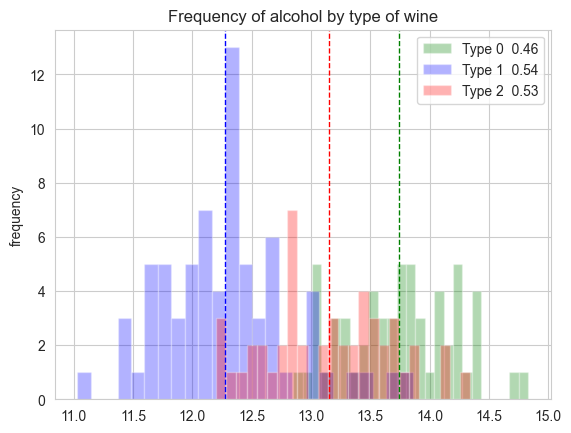

In [244]:
x1 = df.loc[df.target==0, 'alcohol']
x2 = df.loc[df.target==1, 'alcohol']
x3 = df.loc[df.target==2, 'alcohol']

kwargs = dict(alpha=0.3,bins=25)

plt.hist(x1, **kwargs, color='g', label='Type 0'+  str("{:6.2f}".format(x1.std())))
plt.hist(x2, **kwargs, color='b', label='Type 1'+  str("{:6.2f}".format(x2.std())))
plt.hist(x3, **kwargs, color='r', label='Type 2'+  str("{:6.2f}".format(x3.std())))
plt.gca().set(title='Frequency of alcohol by type of wine', ylabel='frequency')
plt.axvline(x1.mean(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(x2.mean(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(x3.mean(), color='r', linestyle='dashed', linewidth=1)
plt.legend();

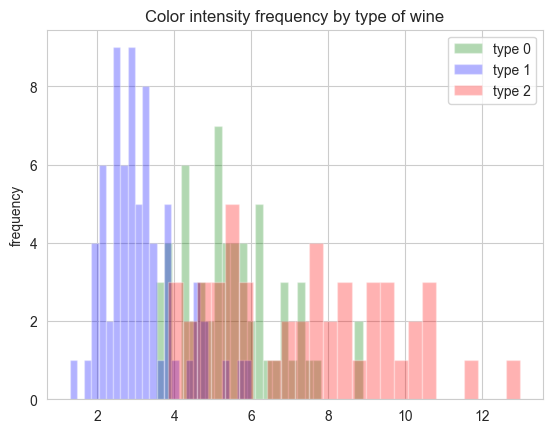

In [245]:
x1 = df.loc[df.target==0, 'color_intensity']
x2 = df.loc[df.target==1, 'color_intensity']
x3 = df.loc[df.target==2, 'color_intensity']

kwargs = dict(alpha=0.3,bins=25)

plt.hist(x1, **kwargs, color='g', label='type 0')
plt.hist(x2, **kwargs, color='b', label='type 1')
plt.hist(x3, **kwargs, color='r', label='type 2')
plt.gca().set(title='Color intensity frequency by type of wine', ylabel='frequency')

plt.legend();

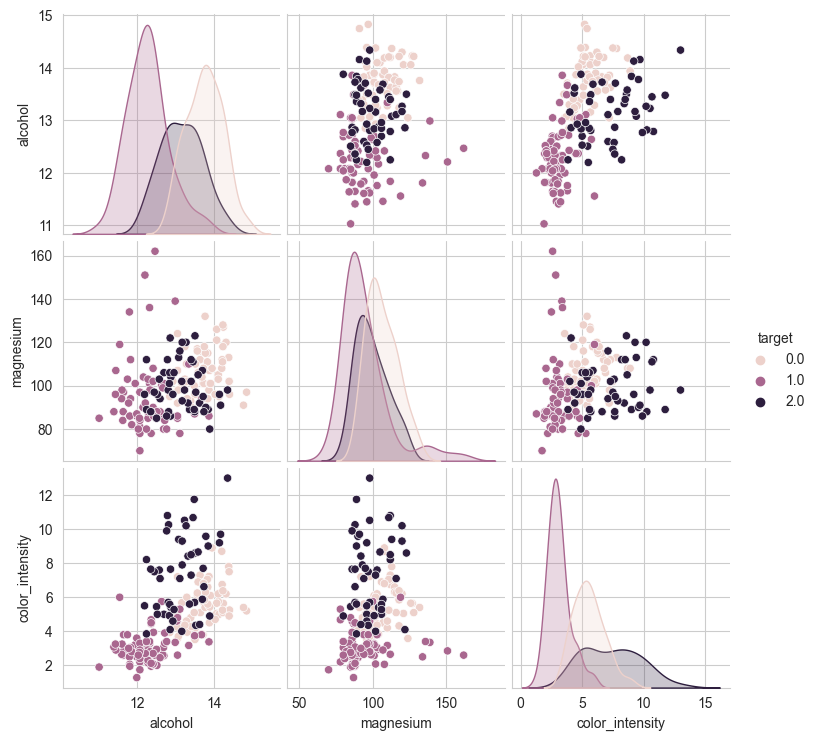

In [246]:
features = df[['alcohol','magnesium','color_intensity','target']]
sns.pairplot(features,hue='target')

### Разделение данных

In [247]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6)

In [248]:
# Масштабирование данных
scaler = StandardScaler()

x_train_scaled_raw = scaler.fit_transform(x_train)
x_test_scaled_raw = scaler.transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled_raw, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled_raw, columns=x.columns)
x_train_scaled.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.797503,-0.516181,1.238635,1.531226,-0.191337,0.760795,-0.884364,1.458252,1.812685,3.084818,-1.771771,-1.088286,-0.191016
1,0.735334,1.367546,-0.516785,0.020122,-0.895220,-1.277562,-1.810864,1.863957,-1.384192,0.288237,-0.719087,-1.294375,-0.457006
2,-1.613934,-0.841641,1.238635,0.157495,-0.472890,0.657150,0.912821,-0.489132,1.443815,-0.880197,-0.061159,0.825389,-0.124519
3,-1.126585,1.209747,-1.170764,-0.117251,-0.965609,-0.621142,-0.515997,0.159996,0.354769,-1.405035,-0.192745,0.516257,-0.510204
4,-0.601749,-0.585218,-0.516785,0.844360,0.512546,-0.621142,-0.013678,-0.083427,-0.101928,-1.106222,0.377459,0.383772,-1.238350


In [249]:
# Подбор наилучших признаков
rfecv = RFECV(estimator=LogisticRegression())

rfecv.fit(x_train_scaled, y_train)

selected_features = list(x_train_scaled.columns[rfecv.support_])

print(f'Оптимальных признаков: {rfecv.n_features_}\nПризнкаи:{selected_features}')

Оптимальных признаков: 9
Признкаи:['alcohol', 'ash', 'alcalinity_of_ash', 'total_phenols', 'flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [250]:
x_train_scaled = x_train_scaled[selected_features]
x_test_scaled = x_test_scaled[selected_features]
x_train_scaled.head()

,alcohol,ash,alcalinity_of_ash,total_phenols,flavanoids,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.797503,1.238635,1.531226,0.760795,-0.884364,3.084818,-1.771771,-1.088286,-0.191016
1,0.735334,-0.516785,0.020122,-1.277562,-1.810864,0.288237,-0.719087,-1.294375,-0.457006
2,-1.613934,1.238635,0.157495,0.657150,0.912821,-0.880197,-0.061159,0.825389,-0.124519
3,-1.126585,-1.170764,-0.117251,-0.621142,-0.515997,-1.405035,-0.192745,0.516257,-0.510204
4,-0.601749,-0.516785,0.844360,-0.621142,-0.013678,-1.106222,0.377459,0.383772,-1.238350


### Подбор гиперпараметров

In [251]:
def get_best_searcher(estimator, param_grid):
    pipeline = Pipeline(
            steps=[
                ("scaling", StandardScaler()),
                ("rfe", RFECV(estimator=LogisticRegression())),
                (
                    "estimator", estimator,
                ),
            ]
        )

    gs = GridSearchCV(
        pipeline,
        [param_grid],
        scoring="roc_auc_ovr",
        cv=5,
        error_score="raise",
    )

    gs.fit(x_train_scaled, y_train)
    
    return gs

In [252]:
# logistic regression
C = np.arange(1e-05, 5, 1)

param_grid = {
    "estimator__C": C,
}

gs = get_best_searcher(LogisticRegression(), param_grid)
print(f"optimal: {gs.best_params_}, best score: {gs.best_score_}")

optimal: {'estimator__C': 1e-05}, best score: 0.9969727891156464


In [313]:
# SVM
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

param_grid = {
    "estimator__C": C,
    "estimator__kernel": kernel,
    "estimator__gamma": gamma,
}

gs = get_best_searcher(SVC(random_state=42, probability=True), param_grid)
print(f"optimal: {gs.best_params_}, best score: {gs.best_score_}")

optimal: {'estimator__C': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}, best score: 0.9746123348979592


In [314]:
# KNN
n_neighbors = [3, 5, 7]
weights = ['uniform', 'distance']

param_grid = {
    "estimator__n_neighbors": n_neighbors,
    "estimator__weights": weights,
}

gs = get_best_searcher(KNeighborsClassifier(), param_grid)
print(f"optimal: {gs.best_params_}, best score: {gs.best_score_}")

optimal: {'estimator__n_neighbors': 5, 'estimator__weights': 'distance'}, best score: 0.975761233489795


In [255]:
# naive bayes
priors = [[0.3, 0.3, 0.4 ]]
var_smoothing = np.logspace(0, -6, num=7)

param_grid = {
    "estimator__priors": priors,
    "estimator__var_smoothing": var_smoothing,
}

gs = get_best_searcher(GaussianNB(), param_grid)
print(f"optimal: {gs.best_params_}, best score: {gs.best_score_}")

optimal: {'estimator__priors': [0.3, 0.3, 0.4], 'estimator__var_smoothing': 1.0}, best score: 0.9956122448979592


In [256]:
# decision tree
max_depth = [3, 4, 5]
min_samples_split = [2, 5]
min_samples_leaf = [2, 4, 6]
max_features = [2, 4, 6]

param_grid = {
    "estimator__max_depth": max_depth,
    "estimator__min_samples_split": min_samples_split,
    "estimator__min_samples_leaf": min_samples_leaf,
    "estimator__max_features": max_features,
}

gs = get_best_searcher(DecisionTreeClassifier(), param_grid)
print(f"optimal: {gs.best_params_}, best score: {gs.best_score_}")


optimal: {'estimator__max_depth': 4, 'estimator__max_features': 2, 'estimator__min_samples_leaf': 6, 'estimator__min_samples_split': 2}, best score: 0.9689378879497926


### Тестирование

In [279]:
accurs = dict()
accurs['one'] = dict()
accurs['rest'] = dict()
accurs['code'] = dict()

times = {'one': dict(), 'rest': dict(), 'code': dict()}

#### OneVsOne

In [280]:
# logistic regression
lg = LogisticRegression(C=1)
clf_one_lg = OneVsOneClassifier(lg)

start_time = time.time()

clf_one_lg.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['one']['lg'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.005980014801025391


In [310]:
# SVM
svm = SVC(random_state=42, probability=True, C=0.25, gamma='scale', kernel='linear')
clf_one_svm = OneVsOneClassifier(svm)

start_time = time.time()

clf_one_svm.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['one']['svm'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.0039980411529541016


In [282]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf_one_knn = OneVsOneClassifier(knn)

start_time = time.time()

clf_one_knn.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['one']['knn'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.0009999275207519531


In [283]:
# naive bayes
nb = GaussianNB(priors=[0.5, 0.5], var_smoothing=0.001)
clf_one_nb = OneVsOneClassifier(nb)

start_time = time.time()

clf_one_nb.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['one']['nb'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.0030167102813720703


In [284]:
# decision tree
dt = DecisionTreeClassifier(max_depth=4, max_features=2, min_samples_leaf=2, min_samples_split=5)
clf_one_dt = OneVsOneClassifier(dt)

start_time = time.time()

clf_one_dt.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['one']['dt'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.003026723861694336


In [311]:
accurs['one']['lg'] = clf_one_lg.score(x_test_scaled, y_test)
accurs['one']['svm'] = clf_one_svm.score(x_test_scaled, y_test)
accurs['one']['knn'] = clf_one_knn.score(x_test_scaled, y_test)
accurs['one']['nb'] = clf_one_nb.score(x_test_scaled, y_test)
accurs['one']['dt'] = clf_one_dt.score(x_test_scaled, y_test)

print(f"accurs of OnevsOne: {accurs['one']}")

accurs of OnevsOne: {'lg': 0.9906542056074766, 'svm': 0.9719626168224299, 'knn': 0.9719626168224299, 'nb': 0.9626168224299065, 'dt': 0.8785046728971962}


#### OneVsRest

In [286]:
# logistic regression
lg = LogisticRegression(C=1)
clf_rest_lg = OneVsRestClassifier(lg)

start_time = time.time()

clf_rest_lg.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['rest']['lg'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.00899958610534668


In [287]:
# SVM
svm = SVC(random_state=42, probability=True, C=0.25, gamma='scale', kernel='linear')
clf_rest_svm = OneVsRestClassifier(svm)

start_time = time.time()

clf_rest_svm.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['rest']['svm'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.003999948501586914


In [288]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf_rest_knn = OneVsRestClassifier(knn)

start_time = time.time()

clf_rest_knn.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['rest']['knn'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.003988742828369141


In [289]:
# naive bayes
nb = GaussianNB(priors=[0.5, 0.5], var_smoothing=0.001)
clf_rest_nb = OneVsRestClassifier(nb)

start_time = time.time()

clf_rest_nb.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['rest']['nb'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.00400853157043457


In [290]:
# decision tree
dt = DecisionTreeClassifier(max_depth=4, max_features=2, min_samples_leaf=2, min_samples_split=5)
clf_rest_dt = OneVsRestClassifier(dt)

start_time = time.time()

clf_rest_dt.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['rest']['dt'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.0039997100830078125


In [291]:
accurs['rest']['lg'] = clf_rest_lg.score(x_test_scaled, y_test)
accurs['rest']['svm'] = clf_rest_svm.score(x_test_scaled, y_test)
accurs['rest']['knn'] = clf_rest_knn.score(x_test_scaled, y_test)
accurs['rest']['nb'] = clf_rest_nb.score(x_test_scaled, y_test)
accurs['rest']['dt'] = clf_rest_dt.score(x_test_scaled, y_test)

print(f"accurs of OnevsRest: {accurs['rest']}")

accurs of OnevsRest: {'lg': 0.9906542056074766, 'svm': 0.9906542056074766, 'knn': 0.9719626168224299, 'nb': 0.9719626168224299, 'dt': 0.9252336448598131}


#### OutputCode

In [292]:
# logistic regression
lg = LogisticRegression(C=1)
clf_code_lg = OutputCodeClassifier(lg, code_size=2, random_state=42)

start_time = time.time()

clf_code_lg.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['code']['lg'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.014013051986694336


In [293]:
# SVM
svm = SVC(random_state=42, probability=True, C=0.25, gamma='scale', kernel='linear')
clf_code_svm = OutputCodeClassifier(svm, code_size=2, random_state=42)

start_time = time.time()

clf_code_svm.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['code']['svm'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.0060002803802490234


In [294]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf_code_knn = OutputCodeClassifier(knn, code_size=2, random_state=42)

start_time = time.time()

clf_code_knn.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['code']['knn'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.005000114440917969


In [295]:
# naive bayes
nb = GaussianNB(priors=[0.5, 0.5], var_smoothing=0.001)
clf_code_nb = OutputCodeClassifier(nb, code_size=2, random_state=42)

start_time = time.time()

clf_code_nb.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['code']['nb'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.0049970149993896484


In [296]:
# decision tree
dt = DecisionTreeClassifier(max_depth=4, max_features=2, min_samples_leaf=2, min_samples_split=5)
clf_code_dt = OutputCodeClassifier(dt, code_size=2, random_state=42)

start_time = time.time()

clf_code_dt.fit(x_train_scaled, y_train)

spend_time = time.time() - start_time

times['code']['dt'] = spend_time
print(f"time spend: {spend_time}")

time spend: 0.006012678146362305


In [297]:
accurs['code']['lg'] = clf_code_lg.score(x_test_scaled, y_test)
accurs['code']['svm'] = clf_code_svm.score(x_test_scaled, y_test)
accurs['code']['knn'] = clf_code_knn.score(x_test_scaled, y_test)
accurs['code']['nb'] = clf_code_nb.score(x_test_scaled, y_test)
accurs['code']['dt'] = clf_code_dt.score(x_test_scaled, y_test)

print(f"accurs of OutputCode: {accurs['code']}")

accurs of OutputCode: {'lg': 0.9813084112149533, 'svm': 0.9906542056074766, 'knn': 0.9719626168224299, 'nb': 0.9626168224299065, 'dt': 0.9345794392523364}


### Анализ

### Точность

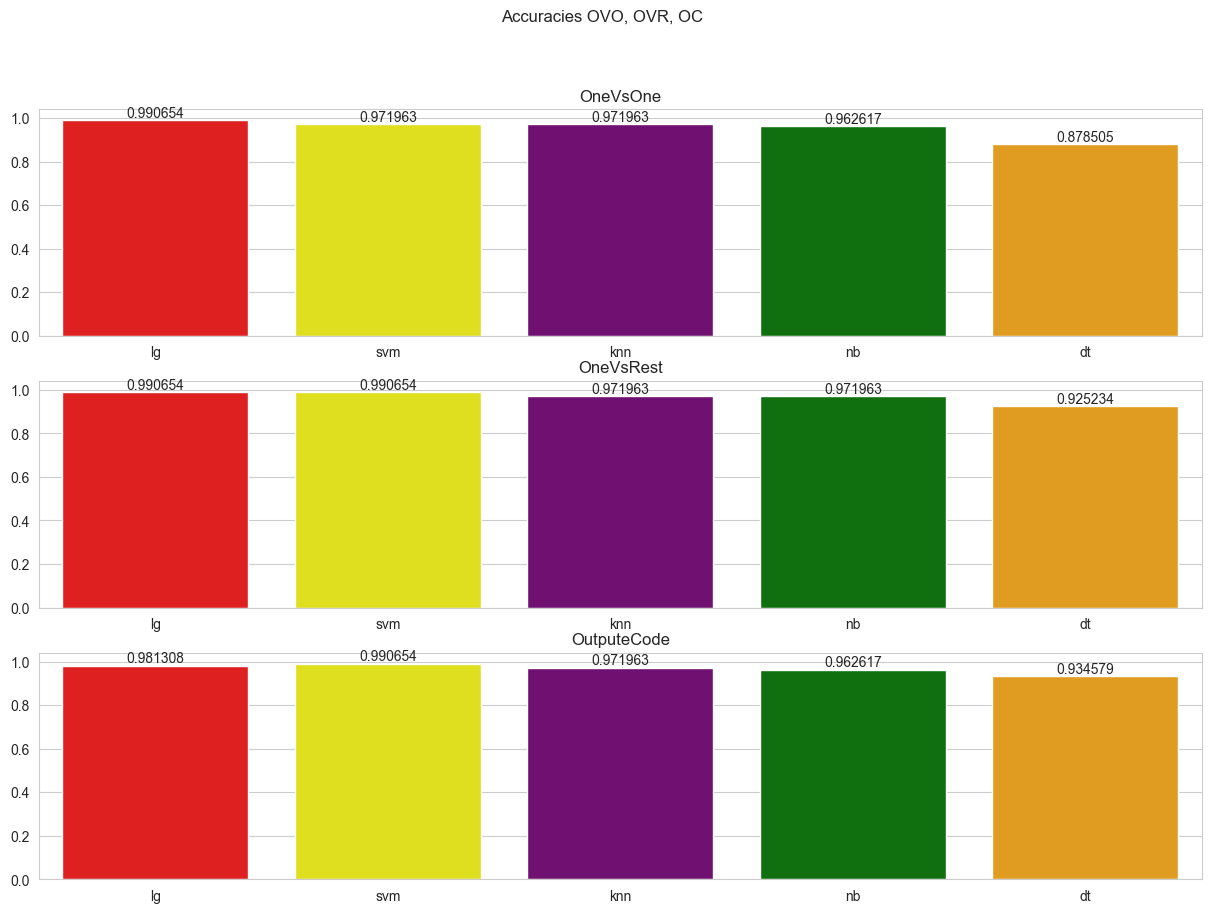

In [298]:
colors = ["red", "yellow", "purple", "green", "orange", "magenta", "blue"]

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=True)
fig.suptitle('Accuracies OVO, OVR, OC')


b1 = sns.barplot(ax=axes[0], x=list(accurs['one'].keys()), y=list(accurs['one'].values()), palette=colors)
axes[0].set_title('OneVsOne')
b1.bar_label(b1.containers[0])

b2 = sns.barplot(ax=axes[1], x=list(accurs['rest'].keys()), y=list(accurs['rest'].values()), palette=colors)
axes[1].set_title('OneVsRest')
b2.bar_label(b2.containers[0])


b3 = sns.barplot(ax=axes[2], x=list(accurs['code'].keys()), y=list(accurs['code'].values()), palette=colors)
axes[2].set_title('OutputeCode')
b3.bar_label(b3.containers[0])


plt.show()

#### Время

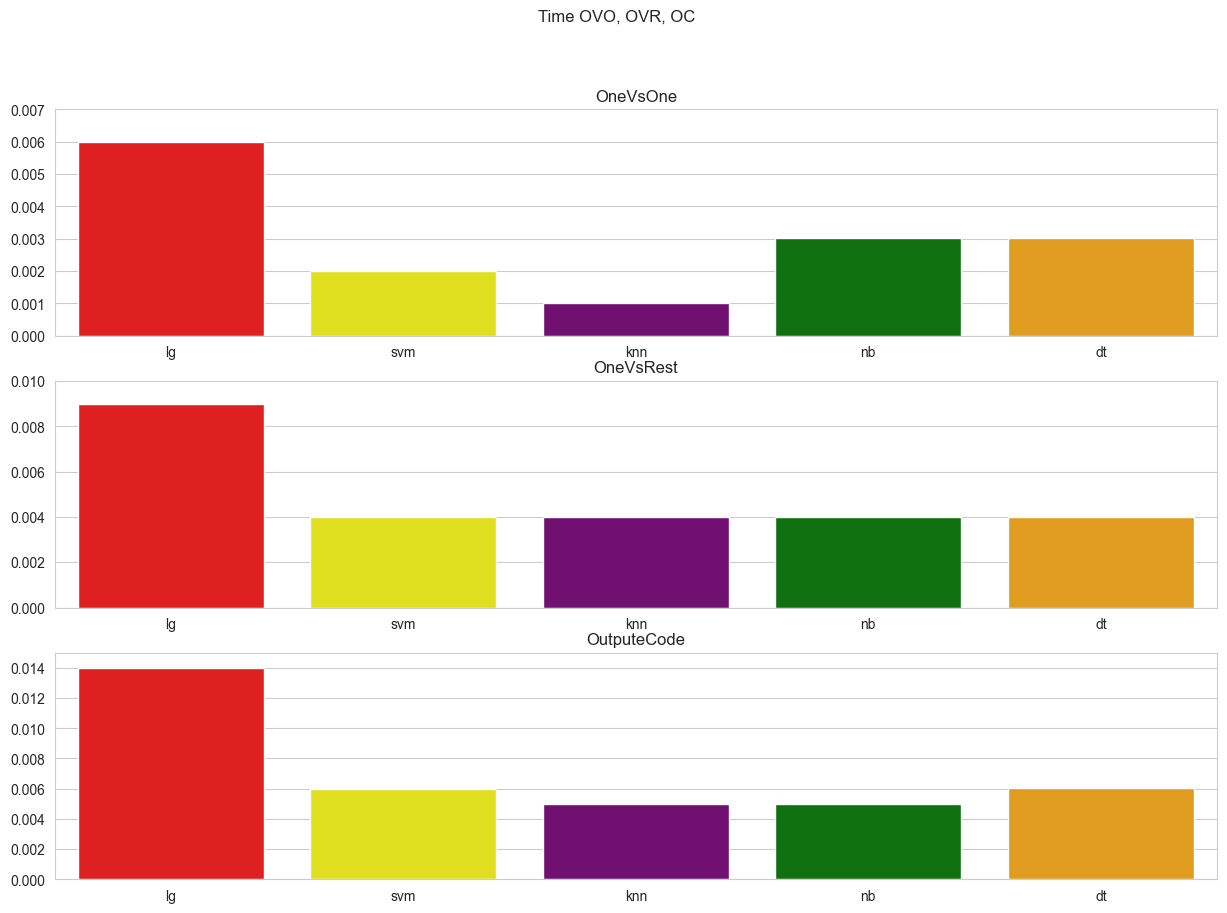

In [305]:
colors = ["red", "yellow", "purple", "green", "orange", "magenta", "blue"]

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharey=False)
fig.suptitle('Time OVO, OVR, OC')


sns.set_style("whitegrid")

b1 = sns.barplot(ax=axes[0], x=list(times['one'].keys()), y=list(times['one'].values()), palette=colors)
axes[0].set_title('OneVsOne')
b1.set_ylim(0, 0.007)

b2 = sns.barplot(ax=axes[1], x=list(times['rest'].keys()), y=list(times['rest'].values()), palette=colors)
axes[1].set_title('OneVsRest')
b2.set_ylim(0, 0.01)

b3 = sns.barplot(ax=axes[2], x=list(times['code'].keys()), y=list(times['code'].values()), palette=colors)
axes[2].set_title('OutputeCode')
b3.set_ylim(0, 0.015)

plt.show()

### Вывод

- Алгоритмы с стратегией OneVsOne обучаются быстрее всего, скорее всего так вышло из-за того, что в данных было всего 3 класса то есть `n_classes * (n_classes - 1) / 2` в данном случае = 3 так же как и для OneVsRest стратегии, где были близкие результаты по времени и также 3 классификатора
- Алгоритмы с стратегией OneVsOne показали высокую точность, но в общем точность немного меньше чем у остальных (OneVsRest и OutputCode)